In [1]:
import torch
from torchsummary import summary
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
import cv2
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Data Loading and Preprocessing

In [3]:
PATH_TO_NPZ = "./drive/MyDrive/data/dump/Data_All_Pix_Extreme.npz"
loaded_data = np.load(PATH_TO_NPZ)
print(loaded_data.files)

['train_x', 'train_y', 'val_x', 'val_y', 'test_x', 'test_y']


In [4]:
train_x = loaded_data['train_x'].astype('float32')
train_y = loaded_data['train_y'].astype('float32')
val_x = loaded_data['val_x'].astype('float32')
val_y = loaded_data['val_y'].astype('float32')
test_x = loaded_data['test_x'].astype('float32')
test_y = loaded_data['test_y'].astype('float32')

print("Training set :", train_x.shape, train_y.shape)
print("Validation set :", val_x.shape, val_y.shape)
print("Test set :", test_x.shape, test_y.shape)

Training set : (10718, 112, 112, 3) (10718, 112, 112, 3)
Validation set : (1191, 112, 112, 3) (1191, 112, 112, 3)
Test set : (1324, 112, 112, 3) (1324, 112, 112, 3)


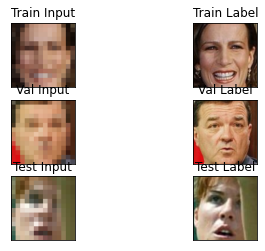

In [5]:
plt.subplot(321), plt.imshow(train_x[0].astype('int')), plt.title("Train Input"), plt.xticks([]), plt.yticks([])
plt.subplot(322), plt.imshow(train_y[0].astype('int')), plt.title("Train Label"), plt.xticks([]), plt.yticks([])
plt.subplot(323), plt.imshow(val_x[0].astype('int')), plt.title("Val Input"), plt.xticks([]), plt.yticks([])
plt.subplot(324), plt.imshow(val_y[0].astype('int')), plt.title("Val Label"), plt.xticks([]), plt.yticks([])
plt.subplot(325), plt.imshow(test_x[0].astype('int')), plt.title("Test Input"), plt.xticks([]), plt.yticks([])
plt.subplot(326), plt.imshow(test_y[0].astype('int')), plt.title("Test Label"), plt.xticks([]), plt.yticks([])
plt.show()

In [6]:
del loaded_data

In [7]:
# Normalizing Images
for i in range(len(train_x)):
    train_x[i] = (train_x[i] - np.mean(train_x[i]))/255.0
    train_y[i] = (train_y[i] - np.mean(train_y[i]))/255.0

for i in range(len(val_x)):
    val_x[i] = (val_x[i] - np.mean(val_x[i]))/255.0
    val_y[i] = (val_y[i] - np.mean(val_y[i]))/255.0

for i in range(len(test_x)):
    test_x[i] = (test_x[i] - np.mean(test_x[i]))/255.0
    test_y[i] = (test_y[i] - np.mean(test_y[i]))/255.0

In [8]:
np.min(train_x), np.max(train_x) , np.min(train_y), np.max(train_y)

(-0.73754174, 0.7140656, -0.78723085, 0.7925307)

In [9]:
# Converting images from HxWxC format to CxHxW format
train_x = np.moveaxis(train_x, -1, 1)
train_y = np.moveaxis(train_y, -1, 1)
val_x = np.moveaxis(val_x, -1, 1)
val_y = np.moveaxis(val_y, -1, 1)
test_x = np.moveaxis(test_x, -1, 1)
test_y = np.moveaxis(test_y, -1, 1)
print("Training set :", train_x.shape, train_y.shape)
print("Validation set :", val_x.shape, val_y.shape)
print("Test set :", test_x.shape, test_y.shape)

Training set : (10718, 3, 112, 112) (10718, 3, 112, 112)
Validation set : (1191, 3, 112, 112) (1191, 3, 112, 112)
Test set : (1324, 3, 112, 112) (1324, 3, 112, 112)


In [10]:
import gc
gc.collect()

9139

In [11]:
train_x = torch.tensor(train_x, dtype=torch.float)
train_y = torch.tensor(train_y, dtype=torch.float)

val_x = torch.tensor(val_x, dtype=torch.float)
val_y = torch.tensor(val_y, dtype=torch.float)

test_x = torch.tensor(test_x, dtype=torch.float)
test_y = torch.tensor(test_y, dtype=torch.float)

In [12]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 4

train_data = TensorDataset(train_x, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_x, val_y)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_x, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=1)

# Utility Functions

In [13]:
def display_something(input, output, label):
    i = np.array((np.moveaxis(input.cpu().numpy(),0,-1) + 1) *127.5, dtype=np.int)
    o = np.array((np.moveaxis(output.data.cpu().numpy(),0,-1) + 1) *127.5, dtype=np.int)
    l = np.array((np.moveaxis(label.cpu().numpy(),0,-1) + 1) *127.5, dtype=np.int)
    plt.subplot(131), plt.imshow(i), plt.title("Input"), plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(o), plt.title("Output"), plt.xticks([]), plt.yticks([])
    plt.subplot(133), plt.imshow(l), plt.title("Label"), plt.xticks([]), plt.yticks([])
    plt.show()

In [14]:
import matplotlib.pyplot as plt
def show_progression(logs, latest_epochs=10):
    # fig, ax = plt.subplots(latest_epochs, 3, figsize=(30,30)) 
    for i in range(latest_epochs):
        i_ = np.array((np.moveaxis(logs[3*i],0,-1) + 1) *127.5, dtype=np.int)
        o = np.array((np.moveaxis(logs[3*i+1],0,-1) + 1) *127.5, dtype=np.int)
        l = np.array((np.moveaxis(logs[3*i+2],0,-1) + 1) *127.5, dtype=np.int)

        print(f"Epoch {i}")
        plt.subplot(131), plt.imshow(i_), plt.title("Input"), plt.xticks([]), plt.yticks([])
        plt.subplot(132), plt.imshow(o), plt.title("Output"), plt.xticks([]), plt.yticks([])
        plt.subplot(133), plt.imshow(l), plt.title("Label"), plt.xticks([]), plt.yticks([])
        plt.show()

# Model Construction

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Conv2d, BatchNorm2d, ReLU, Tanh, ConvTranspose2d, Sigmoid

In [16]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels,):
        super(Residual, self).__init__()

        self.conv_1 = Conv2d(in_channels, 256, kernel_size=3, padding=1)
        self.conv_2 = Conv2d(256, out_channels, kernel_size=3, padding=1)
        self.conv_1x1 = None

        self.bn_1 = BatchNorm2d(256)
        self.bn_2 = BatchNorm2d(out_channels)

        self.relu = ReLU(inplace=True)

        if in_channels != out_channels:
            self.conv_1x1 = Conv2d(in_channels, out_channels, kernel_size=1)


    def forward(self, x):
        x_ = self.relu(self.bn_1(self.conv_1(x)))
        x_ = self.bn_2(self.conv_2(x_))
        x2_ = x
        if self.conv_1x1:
            x2_ = self.conv_1x1(x)
        
        y = x_ + x2_
        return self.relu(y)

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.first_conv_layers = Sequential(
            Conv2d(3, 64,  kernel_size=9, stride=1),
            BatchNorm2d(64),
            ReLU(inplace=True),
            Conv2d(64, 64, kernel_size=4, stride=2),
            BatchNorm2d(64),
            ReLU(inplace=True),
            Conv2d(64, 128, kernel_size=4, stride=2),
            BatchNorm2d(128),
            ReLU(inplace=True),
            Conv2d(128, 256, kernel_size=4, stride=2),
            BatchNorm2d(256),
            ReLU(inplace=True)
        )

        self.second_residual_blocks = Sequential(
            Residual(256, 256),
            Residual(256, 256),
            Residual(256, 256)
        )

        self.third_t_conv = Sequential(
            ConvTranspose2d(256,256, kernel_size=4, stride=2),
            BatchNorm2d(256),
            ReLU(inplace=True),
            ConvTranspose2d(256,128, kernel_size=4, stride=2),
            BatchNorm2d(128),
            ReLU(inplace=True),
            ConvTranspose2d(128,64, kernel_size=4, stride=2),
            BatchNorm2d(64),
            ReLU(inplace=True),
            ConvTranspose2d(64,3, kernel_size=11),# Comeback to this.
            Tanh()
            # ReLU(inplace=True)
            # Sigmoid()
        )

    def forward(self, x):
        x_ = self.first_conv_layers(x)
        x_ = self.second_residual_blocks(x_)
        x_ = self.third_t_conv(x_)
        # print(f"Shape of x_ = {x_.size()}")
        return x_


net = Net()

In [18]:
net.to(device)
summary(net, (3, 112, 112), batch_size=8)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 104, 104]          15,616
       BatchNorm2d-2          [8, 64, 104, 104]             128
              ReLU-3          [8, 64, 104, 104]               0
            Conv2d-4            [8, 64, 51, 51]          65,600
       BatchNorm2d-5            [8, 64, 51, 51]             128
              ReLU-6            [8, 64, 51, 51]               0
            Conv2d-7           [8, 128, 24, 24]         131,200
       BatchNorm2d-8           [8, 128, 24, 24]             256
              ReLU-9           [8, 128, 24, 24]               0
           Conv2d-10           [8, 256, 11, 11]         524,544
      BatchNorm2d-11           [8, 256, 11, 11]             512
             ReLU-12           [8, 256, 11, 11]               0
           Conv2d-13           [8, 256, 11, 11]         590,080
      BatchNorm2d-14           [8, 256,

In [19]:
from torch.nn import MSELoss
from skimage.metrics import structural_similarity
def pixel_loss(y_true, y_pred):
    loss_fn = MSELoss()
    return loss_fn(y_true, y_pred) #/ (112*112*3)

In [20]:
from torch.optim import Adam
optimizer = Adam(net.parameters(), lr=1e-3)

# Side by side Comparision

## On Blurred Set

In [12]:
model_4_blur = torch.load("./drive/MyDrive/data/Final_Model_with_Results4.h5")
model_5_blur = torch.load("./drive/MyDrive/Final_Model_with_Results5.h5")

In [ ]:
model_4_blur.to(device)
model_5_blur.to(device)

Model 4


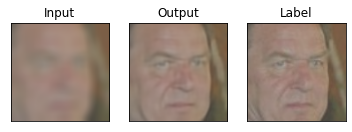

Model 5


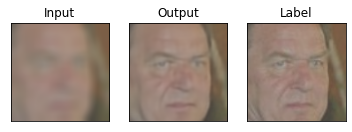

In [51]:
i = 0
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_inputs, b_labels = batch
    if i != 10:
        i+=1
        continue
    with torch.no_grad():
        op1 = model_4_blur(b_inputs)
        op2 = model_5_blur(b_inputs)

    print("Model 4")
    display_something(b_inputs[0], op1[0], b_labels[0])
    print("Model 5")
    display_something(b_inputs[0], op2[0], b_labels[0])
    
    input_img = b_inputs[0].cpu().numpy()
    op1 = op1[0].detach().cpu().numpy()
    op2 = op2[0].detach().cpu().numpy()
    label = b_labels[0].cpu().numpy()

    ssim_1 = structural_similarity(np.moveaxis(op1,0,-1).astype(np.float32), np.moveaxis(label,0,-1).astype(np.float32), multichannel=True)
    ssim_2 = structural_similarity(np.moveaxis(op2,0,-1).astype(np.float32), np.moveaxis(label,0,-1).astype(np.float32), multichannel=True)

    break

In [70]:
def display_something_results(input, output1, output2, label, s1, s2):
    plt.figure(figsize=(10,10))
    i = np.array((np.moveaxis(input,0,-1) + 1) *127.5, dtype=np.int)
    o1 = np.array((np.moveaxis(output1,0,-1) + 1) *127.5, dtype=np.int)
    o2 = np.array((np.moveaxis(output2,0,-1) + 1) *127.5, dtype=np.int)
    l = np.array((np.moveaxis(label,0,-1) + 1) *127.5, dtype=np.int)
    plt.subplot(141), plt.imshow(i), plt.title("Input\n"), plt.xticks([]), plt.yticks([])
    plt.subplot(142), plt.imshow(o1), plt.title(f"MSELoss Model\nSSIM = {s1}"), plt.xticks([]), plt.yticks([])
    plt.subplot(143), plt.imshow(o2), plt.title(f"PixelLoss Model\nSSIM = {s2}"), plt.xticks([]), plt.yticks([])
    plt.subplot(144), plt.imshow(l), plt.title("Label\n"), plt.xticks([]), plt.yticks([])
    plt.show()

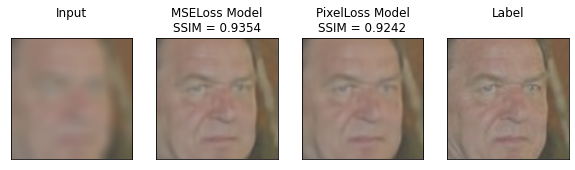

In [71]:
display_something_results(input_img, op1, op2, labels, round(ssim_1,4) ,round(ssim_2,4))

## On Pixelated Set

In [ ]:
import torch

In [76]:
!ls ./drive/MyDrive/data/dump

Data_5000.npz		Data_All_High.npz	  Data_All_Pix_Mod.npz
Data_All_Extreme.npz	Data_All.npz		  Data_All_Pix.npz
Data_All_High_Norm.npz	Data_All_Pix_Extreme.npz


In [22]:
model_4_pix = torch.load("./drive/MyDrive/data/Final_Model_with_Results4_Pix.h5")
model_5_pix = torch.load("./drive/MyDrive/data/Final_Model_with_Results5_Pix.h5")

In [ ]:
model_4_pix.to(device)
model_5_pix.to(device)

Model 4


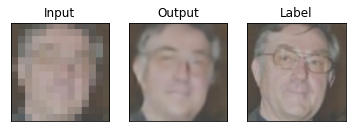

Model 5


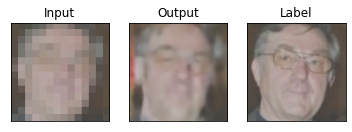

In [26]:
i = 0
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_inputs, b_labels = batch
    if i != 8:
        i+=1
        continue
    with torch.no_grad():
        op1 = model_4_pix(b_inputs)
        op2 = model_5_pix(b_inputs)

    print("Model 4")
    display_something(b_inputs[0], op1[0], b_labels[0])
    print("Model 5")
    display_something(b_inputs[0], op2[0], b_labels[0])
    
    input_img = b_inputs[0].cpu().numpy()
    op1 = op1[0].detach().cpu().numpy()
    op2 = op2[0].detach().cpu().numpy()
    label = b_labels[0].cpu().numpy()

    ssim_1 = structural_similarity(np.moveaxis(op1,0,-1).astype(np.float32), np.moveaxis(label,0,-1).astype(np.float32), multichannel=True)
    ssim_2 = structural_similarity(np.moveaxis(op2,0,-1).astype(np.float32), np.moveaxis(label,0,-1).astype(np.float32), multichannel=True)

    break

In [27]:
def display_something_results(input, output1, output2, label, s1, s2):
    plt.figure(figsize=(10,10))
    i = np.array((np.moveaxis(input,0,-1) + 1) *127.5, dtype=np.int)
    o1 = np.array((np.moveaxis(output1,0,-1) + 1) *127.5, dtype=np.int)
    o2 = np.array((np.moveaxis(output2,0,-1) + 1) *127.5, dtype=np.int)
    l = np.array((np.moveaxis(label,0,-1) + 1) *127.5, dtype=np.int)
    plt.subplot(141), plt.imshow(i), plt.title("Input\n"), plt.xticks([]), plt.yticks([])
    plt.subplot(142), plt.imshow(o1), plt.title(f"MSELoss Model\nSSIM = {s1}"), plt.xticks([]), plt.yticks([])
    plt.subplot(143), plt.imshow(o2), plt.title(f"PixelLoss Model\nSSIM = {s2}"), plt.xticks([]), plt.yticks([])
    plt.subplot(144), plt.imshow(l), plt.title("Label\n"), plt.xticks([]), plt.yticks([])
    plt.show()

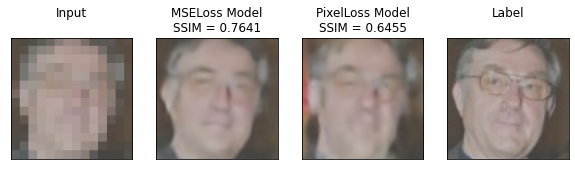

In [29]:
display_something_results(input_img, op1, op2, label, round(ssim_1,4) ,round(ssim_2,4))